In [1]:
# Set random seed
# Reference from: https://qiita.com/okotaku/items/8d682a11d8f2370684c9

In [2]:
import os
import numpy as np
import random as rn
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# build a transfer learning model

In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split

IMG_DIM = (150, 150)

# Load image and covert to numpy array
all_files = glob.glob('fig_wave/*')
# all_files = glob.glob('fig_specgram/*')
all_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in all_files]
all_imgs = np.array(all_imgs)
all_labels = [fn.split('\\')[1].split('.')[0].split('_')[0].strip() for fn in all_files]

# Seperate train and validation dataset
train_imgs, not_train_imgs, train_labels, not_train_labels = train_test_split(all_imgs, all_labels, test_size=0.5, random_state=42)
validation_imgs, test_imgs, validation_labels, test_labels = train_test_split(not_train_imgs, not_train_labels, test_size=0.5, random_state=42)

print('Train dataset shape:', train_imgs.shape, 
      '\nValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (150, 150, 150, 3) 
Validation dataset shape: (75, 150, 150, 3)


In [5]:
# Scale the images
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled = test_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

In [6]:
# Set up parameters for training
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

# Encode text to labels
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)

print (train_labels[0:4], train_labels_enc[0:4])
print (train_labels_enc.shape, validation_labels_enc.shape)

['waterfall', 'pond', 'waterfall', 'waterfall'] [1 0 1 1]
(150,) (75,)


# get VGG model for transfer learning

# feature extraction

In [7]:
import os
import numpy as np
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras import layers

# Get pretrained model (vgg16) for transfer learning
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# Remove the last layer of the pretrained model
output = vgg16.layers[-1].output
output = layers.Flatten()(output)

# Freeze the model which will be extracted as a feature later
vgg16_model = Model(vgg16.input, output)
vgg16_model.trainable = False

# Confirm the trainable status of each layers
for layer in vgg16_model.layers:
    print(layer, layer.trainable)

# Show a summary of the pretrained model. Check the number of trainable parameters
vgg16_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
<keras.engine.input_layer.InputLayer object at 0x0000000010463710> False
<keras.layers.convolutional.Conv2D object at 0x0000000010463780> True
<keras.layers.convolutional.Conv2D object at 0x0000000010C3E320> True
<keras.layers.pooling.MaxPooling2D object at 0x0000000013BDF630> True
<keras.layers.convolutional.Conv2D object at 0x0000000013BDFC18> True
<keras.layers.convolutional.Conv2D object at 0x000000001BC4A710> True
<keras.layers.pooling.MaxPooling2D object at 0x000000001BC61BE0> True
<keras.layers.convolutional.Conv2D object at 0x000000001BC61048> True
<keras.layers.convolutional.Conv2D object at 0x000000001BC959B0> True
<keras.layers.convolutional.Conv2D object at 0x000000001BCAD278> True
<keras.layers.pooling.MaxPooling2D object at 0x000000001BCDBDD8> True
<keras.layers.convolutional.Conv2D object at 0x000000001BCDB860> True
<keras.layers.convolutional.Conv2D object at 0x000000001BCFAF28> True
<keras.layers.c

In [8]:
from keras.applications.imagenet_utils import preprocess_input
# Create functions for feature extraction
def extract_tl_features(model, base_feature_data):
    dataset_tl_features = []
    for index, feature_data in enumerate(base_feature_data):
        if (index+1) % 1000 == 0:
            print('Finished processing', index+1, 'sound feature maps')
        pr_data = process_sound_data(feature_data)
        tl_features = model.predict(pr_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        dataset_tl_features.append(tl_features)
    return np.array(dataset_tl_features)

def process_sound_data(data):
    data = np.expand_dims(data, axis=0)
    data = preprocess_input(data)
    return data

In [9]:
# Extract features from pretrained model (vgg16)
train_vgg16 = extract_tl_features(vgg16_model, train_imgs_scaled)
print (train_imgs_scaled.shape, train_vgg16.shape)
validatation_vgg16 = extract_tl_features(vgg16_model, validation_imgs_scaled)
test_vgg16 = extract_tl_features(vgg16_model, test_imgs_scaled)

(150, 150, 150, 3) (150, 8192)


In [10]:
print (train_vgg16.shape, train_vgg16.shape[1])
print (train_labels_enc.shape, train_labels_enc.shape[0])

(150, 8192) 8192
(150,) 150


In [11]:
from keras.utils import to_categorical

# Convert a vector label to matrix label
train_labels_ohe = to_categorical(train_labels_enc)
validation_labels_ohe = to_categorical(validation_labels_enc)
test_labels_ohe = to_categorical(test_labels_enc)
print (train_labels_ohe.shape,train_labels_ohe.shape[0])

(150, 2) 150


In [12]:
from keras.models import Sequential
from keras import optimizers, losses
from keras import layers

# Create the model
model2 = Sequential()

# Add new layers and pre-trained model (vgg16) as an input feature
model2.add(layers.Dense(1024, activation='relu', 
                       input_shape=(train_vgg16.shape[1],)))
model2.add(layers.Dense(train_labels_ohe.shape[1], activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])

# Show a summary of the model. Check the number of trainable parameters
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 8,391,682
Trainable params: 8,391,682
Non-trainable params: 0
_________________________________________________________________


In [13]:
import time

# Train the model
start = time.time()
vgg16_history = model2.fit(x=train_vgg16, y=train_labels_ohe,
                    validation_data=(validatation_vgg16, validation_labels_ohe),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
end = time.time()
print(end - start)

Instructions for updating:
Use tf.cast instead.
Train on 150 samples, validate on 75 samples
Epoch 1/30
150/150 [==============================] - 2s 14ms/step - loss: 3.8040 - acc: 0.4733 - val_loss: 2.5657 - val_acc: 0.5733
Epoch 2/30
150/150 [==============================] - 1s 6ms/step - loss: 2.3412 - acc: 0.5200 - val_loss: 0.7923 - val_acc: 0.4267
Epoch 3/30
150/150 [==============================] - 1s 7ms/step - loss: 2.0327 - acc: 0.4267 - val_loss: 2.1764 - val_acc: 0.4267
Epoch 4/30
150/150 [==============================] - 1s 6ms/step - loss: 2.1559 - acc: 0.5200 - val_loss: 1.2471 - val_acc: 0.5733
Epoch 5/30
150/150 [==============================] - 1s 6ms/step - loss: 1.6984 - acc: 0.5000 - val_loss: 1.9007 - val_acc: 0.4267
Epoch 6/30
150/150 [==============================] - 1s 7ms/step - loss: 1.3008 - acc: 0.5600 - val_loss: 1.4081 - val_acc: 0.5733
Epoch 7/30
150/150 [==============================] - 1s 7ms/step - loss: 1.1929 - acc: 0.5333 - val_loss: 1.7687 

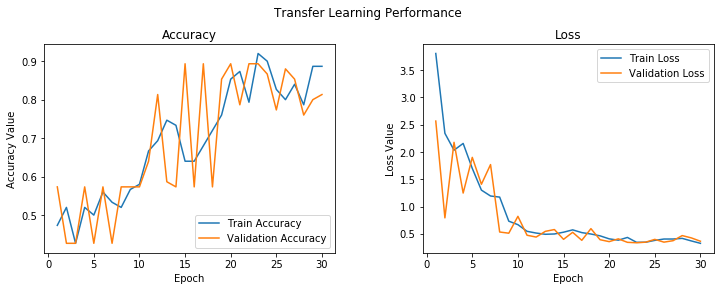

In [14]:
def plot_accuracy(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Transfer Learning Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_lenght = len(history.history['acc'])+1
    epoch_list = list(range(1,epoch_lenght))
    
    # Plot accuracy
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epoch_lenght, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    # Plot loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epoch_lenght, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
plot_accuracy(vgg16_history)

# Fine tuning

In [15]:
# Get the pretrained model (vgg16)
vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the layers except the last 4 layers
for layer in vgg16_model2.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg16_model2.layers:
    print(layer, layer.trainable)
    
vgg16_model2.summary()

<keras.engine.input_layer.InputLayer object at 0x000000001E3AE828> False
<keras.layers.convolutional.Conv2D object at 0x000000001E3AEF60> False
<keras.layers.convolutional.Conv2D object at 0x000000001DC3AEB8> False
<keras.layers.pooling.MaxPooling2D object at 0x000000001E3E3B70> False
<keras.layers.convolutional.Conv2D object at 0x000000001E3E3C88> False
<keras.layers.convolutional.Conv2D object at 0x000000001E3F7D30> False
<keras.layers.pooling.MaxPooling2D object at 0x000000001E42CD68> False
<keras.layers.convolutional.Conv2D object at 0x000000001E42CE48> False
<keras.layers.convolutional.Conv2D object at 0x000000001E4472E8> False
<keras.layers.convolutional.Conv2D object at 0x000000001E472DD8> False
<keras.layers.pooling.MaxPooling2D object at 0x000000001E48EF28> False
<keras.layers.convolutional.Conv2D object at 0x000000001E48E0B8> False
<keras.layers.convolutional.Conv2D object at 0x000000001E4C5C50> False
<keras.layers.convolutional.Conv2D object at 0x000000001E4F9B38> False
<ker

In [16]:
# Create the model
model3 = Sequential()
 
# Add the vgg convolutional base model
model3.add(vgg16_model2)
 
# Add new layers
model3.add(layers.Flatten())
model3.add(layers.Dense(1024, activation='relu'))
model3.add(layers.Dense(train_labels_ohe.shape[1], activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])

# Show a summary of the model. Check the number of trainable parameters
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 23,106,370
Trainable params: 15,471,106
Non-trainable params: 7,635,264
_________________________________________________________________


In [17]:
# Train the model
start = time.time()
vgg16_history3 = model3.fit(x=train_imgs_scaled, y=train_labels_ohe,
                    validation_data=(validation_imgs_scaled, validation_labels_ohe),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
end = time.time()
print(end - start)

Train on 150 samples, validate on 75 samples
Epoch 1/30
150/150 [==============================] - 163s 1s/step - loss: 7.1758 - acc: 0.5067 - val_loss: 6.8771 - val_acc: 0.5733
Epoch 2/30
150/150 [==============================] - 161s 1s/step - loss: 8.3814 - acc: 0.4800 - val_loss: 6.8771 - val_acc: 0.5733
Epoch 3/30
150/150 [==============================] - 162s 1s/step - loss: 8.3814 - acc: 0.4800 - val_loss: 6.8771 - val_acc: 0.5733
Epoch 4/30
150/150 [==============================] - 161s 1s/step - loss: 8.3814 - acc: 0.4800 - val_loss: 6.8771 - val_acc: 0.5733
Epoch 5/30
150/150 [==============================] - 161s 1s/step - loss: 8.3814 - acc: 0.4800 - val_loss: 6.8771 - val_acc: 0.5733
Epoch 6/30
150/150 [==============================] - 162s 1s/step - loss: 8.3814 - acc: 0.4800 - val_loss: 6.8771 - val_acc: 0.5733
Epoch 7/30
150/150 [==============================] - 161s 1s/step - loss: 8.3814 - acc: 0.4800 - val_loss: 6.8771 - val_acc: 0.5733
Epoch 8/30
150/150 [====

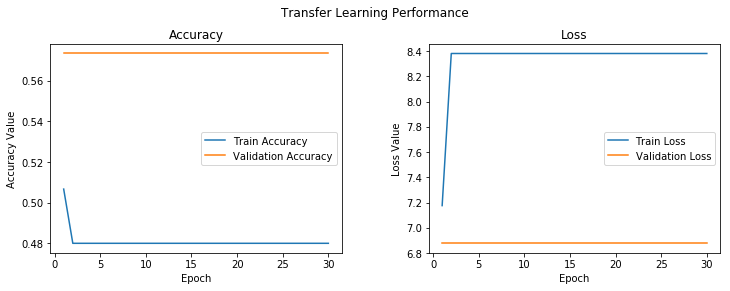

In [18]:
# plot accuracy and loss
plot_accuracy(vgg16_history3)

# Prediction

In [19]:
from sklearn import metrics
def get_metrics(true_labels, predicted_labels):    
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

transfer learning (feature extraction)

In [20]:
# Predict test data
predictions = model2.predict_classes(test_vgg16)
predictions3 = model3.predict_classes(test_imgs_scaled)
print (predictions)
print (predictions3)
print (test_labels_enc)

[1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0
 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0
 0]


In [21]:
class_map = {'0': 'pond', '1':'waterfall'}
test_predict_labels = [class_map[str(label)] for label in predictions]
test_predict_labels3 = [class_map[str(label)] for label in predictions3]
test_actual_labels = [class_map[str(label)] for label in test_labels_enc]

In [22]:
get_metrics(true_labels=test_actual_labels,predicted_labels=test_predict_labels)

Accuracy: 0.8533333333333334
Precision: 0.8884057971014494
Recall: 0.8533333333333334
F1 Score: 0.8516013598139203


In [23]:
import pandas as pd

# Show confusion matrix
labels = ['pond', 'waterfall']
cm = metrics.confusion_matrix(y_true=test_actual_labels, y_pred=test_predict_labels)
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
cm_labeled

,pond,waterfall
pond,35,0
waterfall,11,29


transfer learning (fine tuning)

In [24]:
get_metrics(true_labels=test_actual_labels,predicted_labels=test_predict_labels3)

Accuracy: 0.4666666666666667
Precision: 0.21777777777777776
Recall: 0.4666666666666667
F1 Score: 0.296969696969697


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
# Show confusion matrix
cm = metrics.confusion_matrix(y_true=test_actual_labels, y_pred=test_predict_labels3)
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
cm_labeled

,pond,waterfall
pond,35,0
waterfall,40,0
